In [1]:
1+3

4

In [3]:
1+3

4

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003682768, 'queue_time': 0.056003432, 'total_time': 0.053682768}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_c527211fd1', 'finish_reason': 'stop', 'logprobs': None}, id='run-7ce7d0ae-94e5-45c2-bff1-4e188775f7e2-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [192]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.types import Command, interrupt

class State(TypedDict):
    input : str
    output : str


def step_1(state):
    print(state["output"]+" ---Step 1--- "+state["input"])
    return {"input": "Hello James"}


def step_2(state):
    print(state["output"]+" ---Step 2--- "+state["input"])
    return {"input": "Hello Piyush", "output": "Hello Piyush"}


def step_3(state):
    print(state["output"]+" ---Step 3--- "+state["input"])
    return {"input": "Hello Shkhar", "output": "Hello Piyush"}

def step_4(state):
    print(state["output"]+" ---Step 4--- "+state["input"])
    return {"input": "Hello Jay", "output": "Hello Piyush"}

def step_5(state):
    print(state["output"]+" ---Step 5--- "+state["input"])
    return {"input": "Hello DJ", "output": "Hello Piyush"}

def should_continue(state: State):
    print("should_continue XXXX ",state)
    input = state.get('input',None)
    print("should_continue XXXX ",input)
    if input:
        return "step_2"
    return "step_5"

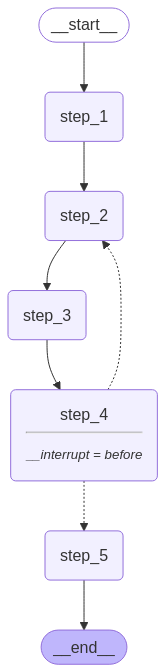

In [194]:
builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_node("step_4", step_4)
builder.add_node("step_5", step_5)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", "step_4")
builder.add_conditional_edges("step_4", should_continue, ["step_5", "step_2"])
builder.add_edge("step_5", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_4"])
# graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [195]:
# Input
initial_input = {"input": "hello world", "output": ""}

# Thread
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

state = graph.get_state(thread)
state.next


{'input': 'hello world', 'output': ''}
 ---Step 1--- hello world
{'input': 'Hello James', 'output': ''}
 ---Step 2--- Hello James
{'input': 'Hello Piyush', 'output': 'Hello Piyush'}
Hello Piyush ---Step 3--- Hello Piyush
{'input': 'Hello Shkhar', 'output': 'Hello Piyush'}


('step_4',)

In [201]:
print("Current state!")
print(graph.get_state(thread).values)


Current state!
{'input': 'Hello Shkhar', 'output': 'Hello Piyush'}


In [197]:

graph.update_state(thread, {"input": "Kirti ", "output": ""}, as_node="step_2")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00a575-bad4-6bdd-8004-e44f57298cef'}}

In [198]:

state = graph.get_state(thread)
state.next

('step_3',)

In [186]:
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)

 ---Step 1--- hello world
{'step_1': {'input': 'Hello James'}}
 ---Step 2--- Hello James
{'step_2': {'input': 'Hello Piyush', 'output': 'Hello Piyush'}}
Hello Piyush ---Step 3--- Hello Piyush
{'step_3': {'input': 'Hello Shkhar', 'output': 'Hello Piyush'}}
{'__interrupt__': ()}


In [200]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'input': 'Hello Shkhar', 'output': 'Hello Piyush'}
Hello Piyush ---Step 4--- Hello Shkhar
should_continue XXXX  {'input': 'Hello Jay', 'output': 'Hello Piyush'}
should_continue XXXX  Hello Jay
{'input': 'Hello Jay', 'output': 'Hello Piyush'}
Hello Piyush ---Step 2--- Hello Jay
{'input': 'Hello Piyush', 'output': 'Hello Piyush'}
Hello Piyush ---Step 3--- Hello Piyush
{'input': 'Hello Shkhar', 'output': 'Hello Piyush'}


In [ ]:
from langgraph.graph import StateGraph
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langchain_core.runnables import RunnableLambda

# Define the state
class State(TypedDict):
    query : str
    response : str
    human_override : str

# Step 1: Start Query
def start_query(state : State):
    print("Step 1: Accepting Query")
    state.query = input("Enter your query: ")  # Simulating user input
    return {"query": "Hello Piyush", "output": "Hello Piyush"}

# Step 2: Process Query
def process_query(state : State):
    print("Step 2: Processing Query")
    state.response = f"Brief response to: {state.query}"  # Simulating LLM response
    return state

# Step 3: Generate Response
def generate_response(state : State):
    print("Step 3: Generating Response")
    return state

# Step 4: Human Review (Interrupt Point)
def human_review(state : State):
    print("Step 4: Human Review")
    user_input = input("Approve response? (yes/no): ").strip().lower()
    state.human_override = user_input == "no"  # If "no", restart process
    return state

# Step 5: Finalize and Return
def finalize(state : State):
    print("Step 5: Finalizing Response")
    print(f"Final Response: {state.response}")
    return state

# Condition for interruption
def should_continue(state : State):
    return "retry" if state.human_override else "finalize"



In [112]:
# Building the Graph
workflow = StateGraph(State)
workflow.add_node("start_query", start_query)
workflow.add_node("process_query", process_query)
workflow.add_node("generate_response", generate_response)
workflow.add_node("human_review", human_review)
workflow.add_node("finalize", finalize)

# Defining edges
workflow.add_edge(START, "start_query")
workflow.add_edge("start_query", "process_query")
workflow.add_edge("process_query", "generate_response")
workflow.add_edge("generate_response", "human_review")
# workflow.add_edge("human_review", END)   

# Adding conditional edge at Step 4
workflow.add_conditional_edges("human_review", should_continue, {"retry": "process_query", "finalize": "finalize"})

# Compiling and Running
app = workflow.compile()
app.invoke(State())
display(Image(app.get_graph().draw_mermaid_png()))


Step 1: Accepting Query


Step 2: Processing Query


AttributeError: 'dict' object has no attribute 'query'

In [109]:
# Input
initial_input = {"query": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# for event in app.stream(initial_input, thread, stream_mode="updates"):
#     print(event)

app.invoke({"query":"What is AI ?"})

# state = app.get_state(thread)
# state.next

Step 1: Accepting Query
Step 2: Processing Query


AttributeError: 'dict' object has no attribute 'query'

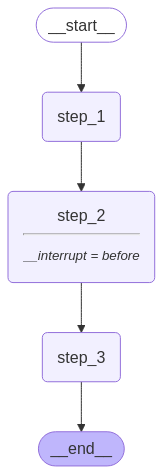

In [113]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_2"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [115]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---


In [119]:
print("Current state!")
print(graph.get_state(thread).values)

graph.update_state(thread, {"input": "hello universe!"})

print("---\n---\nUpdated state!")
print(graph.get_state(thread).values)

Current state!
{'input': 'hello world'}
---
---
Updated state!
{'input': 'hello universe!'}


In [118]:
# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)
    

{'input': 'hello world'}
---Step 1---


In [120]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'input': 'hello universe!'}
---Step 2---
---Step 3---
